# Speech-to-Text API Experimentation

## Import Libraries

In [1]:
from google.cloud import speech_v1p1beta1 as speech
from google.cloud import storage

import spacy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Reshape, Bidirectional
from tensorflow.keras import backend as K

from tqdm import tqdm 

import gensim.downloader as api

import string
import json 
import re

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/ekin/Downloads/hack.json"

## Using Client Library

In [2]:
'''
Function to test credentials
'''
def implicit():
    from google.cloud import storage

    # If you don't specify credentials when constructing the client, the
    # client library will look for credentials in the environment.
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)

In [3]:
implicit()

[]


In [4]:
'''
Test speech client and transcription API on a sample audio file. 
'''
# Instantiates a client
client = speech.SpeechClient()

# The name of the audio file to transcribe
gcs_uri = "gs://cloud-samples-data/speech/brooklyn_bridge.raw"

audio = speech.RecognitionAudio(uri=gcs_uri)

config = speech.RecognitionConfig(
    encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
    sample_rate_hertz=16000,
    language_code="en-US",
)

# Detects speech in the audio file
response = client.recognize(config=config, audio=audio)

print(response.results)

for result in response.results:
    print("Transcript: {}".format(result.alternatives[0].transcript))
    print("Confidence: {}".format(result.alternatives[0].confidence))

[alternatives {
  transcript: "how old is the Brooklyn Bridge"
  confidence: 0.9823954
}
language_code: "en-us"
]
Transcript: how old is the Brooklyn Bridge
Confidence: 0.9823954105377197


## Transcribing Long Audio Files

In [5]:
def transcribe_gcs(gcs_uri):
    """Asynchronously transcribes the audio file specified by the gcs_uri."""
    client = speech.SpeechClient()

    audio = speech.RecognitionAudio(uri=gcs_uri)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.FLAC,
        sample_rate_hertz=48000,
        audio_channel_count=2,
        language_code="en-US",
        enable_automatic_punctuation=True,
        enable_word_time_offsets=True, 
        enable_word_confidence=True,
    )

    operation = client.long_running_recognize(config=config, audio=audio)

    print("Waiting for operation to complete...")
    response = operation.result(timeout=90)

    # Each result is for a consecutive portion of the audio. Iterate through
    # them to get the transcripts for the entire audio file.
    for result in response.results:
        # The first alternative is the most likely one for this portion.
        alternative = result.alternatives[0]
        print(u"Transcript: {}".format(result.alternatives[0].transcript))
        print("Confidence: {}".format(result.alternatives[0].confidence))
        
    return response.results

In [6]:
example_gcs_uri = "gs://hack_the_ne/example_1.flac"
results = transcribe_gcs(example_gcs_uri)

Waiting for operation to complete...
Transcript: Hi, my name is I can see you and today I'm going to be presenting our hack the Northeast project, which is I present. So first our presentation consists of three main components with front-end UI and ux developer has developed a web service which allows the user to
Confidence: 0.9569840431213379


## Transcript Processing Algorithms

In [7]:
result = results[0].alternatives[0]
transcript = result.transcript
words = result.words

In [8]:
print(transcript)

Hi, my name is I can see you and today I'm going to be presenting our hack the Northeast project, which is I present. So first our presentation consists of three main components with front-end UI and ux developer has developed a web service which allows the user to


In [129]:
'''
Remove punctuation from a `transcript` string
'''
def clean(transcript): 
    cleaned = transcript.translate(str.maketrans('', '', string.punctuation))
    
    # Temporarily remove `Laughter` from the transcript, but could be used later
    cleaned = cleaned.replace('Laughter', '')
    cleaned = cleaned.replace('Applause', '')
    
    # Remove hyphens 
    cleaned = cleaned.replace('—', '')
    
    # turn all characters into lowercase
    return cleaned.lower()

### Clarity
Measurement of how understandable your speech is. Based on the confidence of the overall transcription. 

In [10]:
clarity = result.confidence

### Brevity
Count the number of filler_words or hedging language phrases. 

In [130]:
'''
This function returns a count of how many times 
each phrase in the `phrases` list is in the 
`transcript` string. 
'''
def count_phrases(transcript, phrases, return_phrase_counts=True): 
    transcript = clean(transcript) # remove punctuation and lowercase
    space_transcript = ' ' + transcript + ' '
    phrase_counts = {}
    all_counts = 0 
    for phrase in phrases: 
        space_phrase = ' ' + phrase + ' '
        count = space_transcript.count(space_phrase)
        if count > 0: 
            phrase_counts[phrase] = count
            all_counts = all_counts + count
    
    if return_phrase_counts: 
        return phrase_counts, all_counts # Return the counts for each filler phrase
    else:
        return all_counts # Only return the total number of counts

In [131]:
filler_words = [
    'like', 
    'i mean',
    'you know', 
    'so', 
    'well', 
    'you see', 
]

hedging_language = [
    'kind of', 
    'i think', 
    'maybe',
]

In [132]:
test_string = "so I think I will begin with this like kind of interesting thing maybe"
filler_phrase_counts, filler_all_counts = count_phrases(test_string, filler_words)
print(filler_phrase_counts) 

{'like': 1, 'so': 1}


In [133]:
hedging_phrase_counts, hedging_all_counts = count_phrases(test_string, hedging_language)
print(hedging_phrase_counts)

{'kind of': 1, 'i think': 1, 'maybe': 1}


### Cadence
Counting the number of words spoken every second. 

* Average is 130 words per minute | 2.166 words per second (avg)
* Takes us around 0.46 seconds to speak one word

In [15]:
'''
Compute the total duration of the speech in seconds, given
the dict of words. 
'''
def speech_time(words): 
    first_word = words[0]
    last_word = words[-1]
    
    start_time = first_word.start_time.total_seconds()
    end_time = last_word.end_time.total_seconds()
    
    return end_time - start_time

'''
Computes the number of words spoken in the speech per 
second, given `words` as a dict. 
'''
def words_per_second(words, time): 
    return len(words) / time 

In [16]:
'''
Perform actual computations
'''
total_time = speech_time(words)
pace = words_per_second(words, total_time)

print('Total Time: ', total_time)
print('Pace (words / second): ', pace) # slower than average

Total Time:  15.3
Pace (words / second):  0.9150326797385621


In [17]:
'''
Compute the number of seconds for each word in `words`
'''

def seconds_per_word(words, verbose=False):
    word_times = {}
    for word_info in words:
        word = word_info.word
        start_time = word_info.start_time.total_seconds()
        end_time = word_info.end_time.total_seconds()
        confidence = word_info.confidence

        if verbose: 
            print(
                f"{word}, start_time: {start_time}, end_time: {end_time}, confidence: {confidence}"
            )

        time_of_word = round(end_time - start_time, 3)
        word_times[word] = time_of_word
        
    return word_times

In [18]:
word_times = seconds_per_word(words, verbose=True)
# word_times = {k: v for k, v in sorted(word_times.items(), key=lambda item: item[1])} # sorted
print(word_times)

I'm, start_time: 1.3, end_time: 1.9, confidence: 0.9876290559768677
going, start_time: 1.9, end_time: 2.1, confidence: 0.9876290559768677
to, start_time: 2.1, end_time: 2.2, confidence: 0.9876290559768677
test, start_time: 2.2, end_time: 2.5, confidence: 1.0
maybe, start_time: 2.5, end_time: 4.7, confidence: 0.9239681959152222
that's, start_time: 4.7, end_time: 5.1, confidence: 0.9249534010887146
a, start_time: 5.1, end_time: 5.4, confidence: 0.9668338894844055
bit, start_time: 5.4, end_time: 5.6, confidence: 0.9876290559768677
different, start_time: 5.6, end_time: 6.2, confidence: 1.0
interesting, start_time: 6.2, end_time: 13.7, confidence: 0.8979593515396118
absolutely, start_time: 13.7, end_time: 14.9, confidence: 0.9249765872955322
totally, start_time: 14.9, end_time: 15.2, confidence: 0.9876290559768677
no, start_time: 15.2, end_time: 16.4, confidence: 0.8444064855575562
way, start_time: 16.4, end_time: 16.6, confidence: 0.8684027194976807
{"I'm": 0.6, 'going': 0.2, 'to': 0.1, 't

In [19]:
# todo: plot each word on a histogram and also plot an average line 
# simpler, just count the number of words that are greater than average, and compare
def classify_pauses(baseline_time): 
    normal_words = {}
    delayed_words = {}
    avg_time = 0.46
    for word, time in word_times.items(): 
        if time > avg_time: 
            delayed_words[word] = time
        else:
            normal_words[word] = time
    return normal_words, delayed_words

In [20]:
avg_time = 0.5 # half a second per word on avg. 
normal_words, delayed_words = classify_pauses(avg_time)
print('Normal words: ', normal_words)
print('Delayed words: ', delayed_words)

Normal words:  {'going': 0.2, 'to': 0.1, 'test': 0.3, "that's": 0.4, 'a': 0.3, 'bit': 0.2, 'totally': 0.3, 'way': 0.2}
Delayed words:  {"I'm": 0.6, 'maybe': 2.2, 'different': 0.6, 'interesting': 7.5, 'absolutely': 1.2, 'no': 1.2}


### Strong Vocabulary (Passion/Urgency)

In [21]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(transcript)

In [22]:
# Analyze syntax
noun_phrases = [chunk.text for chunk in doc.noun_chunks]
verb_phrases = [chunk.text for chunk in doc.noun_chunks]

print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])
print("Adjectives:", [token.lemma_ for token in doc if token.pos_ == "ADJ"])

# for token in doc: 
#     print(token.pos_)
# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

Noun phrases: ['I', 'no way']
Verbs: ['go', 'test']
Adjectives: ['different', 'interesting']


In [23]:
# todo: rate the adjectives based on level of neutrality

## Sentiment Analysis API

In [135]:
from google.cloud import language_v1

def sample_analyze_sentiment(text_content):
    """
    Analyzing Sentiment in a String
    
    Returns dict of scores for the entire document, and a list of
    dicts representing scores for each sentence in the document. 

    Args:
      text_content The text content to analyze
    """

    client = language_v1.LanguageServiceClient()

    # Available types: PLAIN_TEXT, HTML
    type_ = language_v1.Document.Type.PLAIN_TEXT

    language = "en"
    document = {"content": text_content, "type_": type_, "language": language}

    # Available values: NONE, UTF8, UTF16, UTF32
    encoding_type = language_v1.EncodingType.UTF8

    response = client.analyze_sentiment(request = {'document': document, 'encoding_type': encoding_type})
    
    # Get overall sentiment of the input document
    print(u"Document sentiment score: {}".format(response.document_sentiment.score))
    print(
        u"Document sentiment magnitude: {}".format(
            response.document_sentiment.magnitude
        )
    )
    
    # Save doc stats to variable
    doc_stats = {
        'sentiment' : response.document_sentiment.score, 
        'magnitude' : response.document_sentiment.magnitude,
    }
    

    # Get sentiment for all sentences in the document
    sentences_stats = []
    for sentence in response.sentences:
        sentence_stats = {
            'sentence' : sentence.text.content,
            'sentiment' : sentence.sentiment.score, 
            'magnitude' : sentence.sentiment.magnitude,
        }
        
        sentences_stats.append(sentence_stats)
        
        print(u"Sentence text: {}".format(sentence.text.content))
        print(u"Sentence sentiment score: {}".format(sentence.sentiment.score))
        print(u"Sentence sentiment magnitude: {}".format(sentence.sentiment.magnitude))

    # Get the language of the text, which will be the same as
    # the language specified in the request or, if not specified,
    # the automatically-detected language.
    print(u"Language of the text: {}".format(response.language))
    
    return doc_stats, sentences_stats


In [136]:
test = 'My name is Ekin. Nice to meet you.'
doc_stats, sentences_stats = sample_analyze_sentiment(transcript)

Document sentiment score: 0.20000000298023224
Document sentiment magnitude: 0.5
Sentence text: Hi, my name is I can see you and today I'm going to be presenting our hack the Northeast project, which is I present.
Sentence sentiment score: 0.10000000149011612
Sentence sentiment magnitude: 0.10000000149011612
Sentence text: So first our presentation consists of three main components with front-end UI and ux developer has developed a web service which allows the user to
Sentence sentiment score: 0.4000000059604645
Sentence sentiment magnitude: 0.4000000059604645
Language of the text: en


In [138]:
print('Doc stats: ', doc_stats)
print('\n')
print('Sentences stats: ', sentences_stats)

Doc stats:  {'sentiment': 0.20000000298023224, 'magnitude': 0.5}


Sentences stats:  [{'sentence': "Hi, my name is I can see you and today I'm going to be presenting our hack the Northeast project, which is I present.", 'sentiment': 0.10000000149011612, 'magnitude': 0.10000000149011612}, {'sentence': 'So first our presentation consists of three main components with front-end UI and ux developer has developed a web service which allows the user to', 'sentiment': 0.4000000059604645, 'magnitude': 0.4000000059604645}]


## TED Analytics

In [128]:
def load_wv():
    # this line of code needs to run asynchronously first
    wv = api.load('word2vec-google-news-300')
    return wv

def create_embedding(transcript, wv):
#     print(transcript)
    X = []
    found_words = []
    transcript = clean(transcript) # remove any punctuation
    
    print(transcript)
    words = transcript.split()
    for word in words: 
        try:
            found_words.append(wv[word])
        except: 
            continue
            
    embedding = np.asarray(found_words)
    mean = np.mean(embedding, axis=0)
    mean = mean.tolist()

    if type(mean) == list: 
        X.append(mean)

    X = np.array(X)
    return X

In [125]:
def perform_analysis(transcript):
    wv = load_wv()
    embedding = create_embedding(transcript, wv)
    
    model_filepath = './ted_analysis_model'
    model = tf.keras.models.load_model(model_filepath)
    
    pred = model.predict(embedding)[0]
    cols = ['Beautiful', 'Confusing', 'Courageous', 'Funny', 'Informative', 'Ingenious', 'Inspiring', 'Longwinded', 'Unconvincing', 'Fascinating', 'Jaw-dropping', 'Persuasive', 'OK', 'Obnoxious']
    
    ted_dict = {}
    for val, col in zip(pred, cols):
        ted_dict[col] = val
    return ted_dict # can be converted to a JSON

In [126]:
ted_dict = perform_analysis(transcript)

hi my name is i can see you and today im going to be presenting our hack the northeast project which is i present so first our presentation consists of three main components with frontend ui and ux developer has developed a web service which allows the user to


In [127]:
print(ted_dict)

{'Beautiful': 0.08486959, 'Confusing': 0.025597274, 'Courageous': 0.004894078, 'Funny': 0.042433977, 'Informative': 0.38298982, 'Ingenious': 0.98094106, 'Inspiring': 0.28280404, 'Longwinded': 0.013673663, 'Unconvincing': 0.05666706, 'Fascinating': 0.9619733, 'Jaw-dropping': 0.59125984, 'Persuasive': 0.00097215176, 'OK': 0.21875376, 'Obnoxious': 0.05292952}


### TED Analysis Experimentation

In [38]:
wv = load_wv()

In [39]:
embedding = create_embedding(transcript, wv)

In [42]:
model_filepath = './ted_analysis_model'
model = tf.keras.models.load_model(model_filepath)

In [50]:
pred = model.predict(embedding)[0]

In [51]:
print(transcript)

I'm going to test maybe that's a bit different interesting absolutely totally no way


In [52]:
cols = ['Beautiful', 'Confusing', 'Courageous', 'Funny', 'Informative', 'Ingenious', 'Inspiring', 'Longwinded', 'Unconvincing', 'Fascinating', 'Jaw-dropping', 'Persuasive', 'OK', 'Obnoxious']

In [55]:
ted_dict = {}
for val, col in zip(pred, cols):
    ted_dict[col] = val
print(ted_dict)

{'Beautiful': 0.11447036, 'Confusing': 0.10280144, 'Courageous': 0.0026097298, 'Funny': 0.81440914, 'Informative': 0.11125913, 'Ingenious': 0.7225983, 'Inspiring': 0.111739606, 'Longwinded': 0.026772916, 'Unconvincing': 0.09550491, 'Fascinating': 0.8304244, 'Jaw-dropping': 0.35544878, 'Persuasive': 0.0057587028, 'OK': 0.45375717, 'Obnoxious': 0.10564661}


## Presentation Summary
* Uses the pre-trained BERT model to summarize your presentation. 

In [9]:
from summarizer import Summarizer

In [10]:
model = Summarizer()

In [19]:
ted = """Good morning. How are you?(Laughter)It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we've had and in all of the people here. Just the variety of it and the range of it. The second is that it's put us in a place where we have no idea what's going to happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don't you? I find this very interesting. If you're at a dinner party, and you say you work in education — Actually, you're not often at dinner parties, frankly.(Laughter)If you work in education, you're not asked.(Laughter)And you're never asked back, curiously. That's strange to me. But if you are, and you say to somebody, you know, they say, "What do you do?" and you say you work in education, you can see the blood run from their face. They're like, "Oh my God," you know, "Why me?"(Laughter)"My one night out all week."(Laughter)But if you ask about their education, they pin you to the wall. Because it's one of those things that goes deep with people, am I right? Like religion, and money and other things. So I have a big interest in education, and I think we all do. We have a huge vested interest in it, partly because it's education that's meant to take us into this future that we can't grasp. If you think of it, children starting school this year will be retiring in 2065. Nobody has a clue, despite all the expertise that's been on parade for the past four days, what the world will look like in five years' time. And yet we're meant to be educating them for it. So the unpredictability, I think, is extraordinary.And the third part of this is that we've all agreed, nonetheless, on the really extraordinary capacities that children have — their capacities for innovation. I mean, Sirena last night was a marvel, wasn't she? Just seeing what she could do. And she's exceptional, but I think she's not, so to speak, exceptional in the whole of childhood. What you have there is a person of extraordinary dedication who found a talent. And my contention is, all kids have tremendous talents. And we squander them, pretty ruthlessly.So I want to talk about education and I want to talk about creativity. My contention is that creativity now is as important in education as literacy, and we should treat it with the same status.(Applause) Thank you.(Applause)That was it, by the way. Thank you very much.(Laughter)So, 15 minutes left.(Laughter)Well, I was born... no.(Laughter)I heard a great story recently — I love telling it — of a little girl who was in a drawing lesson. She was six, and she was at the back, drawing, and the teacher said this girl hardly ever paid attention, and in this drawing lesson, she did. The teacher was fascinated. She went over to her, and she said, "What are you drawing?" And the girl said, "I'm drawing a picture of God." And the teacher said, "But nobody knows what God looks like." And the girl said, "They will, in a minute."(Laughter)When my son was four in England — Actually, he was four everywhere, to be honest.(Laughter)If we're being strict about it, wherever he went, he was four that year. He was in the Nativity play. Do you remember the story?(Laughter)No, it was big, it was a big story. Mel Gibson did the sequel, you may have seen it.(Laughter)"Nativity II." But James got the part of Joseph, which we were thrilled about. We considered this to be one of the lead parts. We had the place crammed full of agents in T-shirts: "James Robinson IS Joseph!" (Laughter) He didn't have to speak, but you know the bit where the three kings come in? They come in bearing gifts, gold, frankincense and myrrh. This really happened. We were sitting there and I think they just went out of sequence, because we talked to the little boy afterward and we said, "You OK with that?" And he said, "Yeah, why? Was that wrong?" They just switched. The three boys came in, four-year-olds with tea towels on their heads, and they put these boxes down, and the first boy said, "I bring you gold." And the second boy said, "I bring you myrrh." And the third boy said, "Frank sent this."(Laughter)What these things have in common is that kids will take a chance. If they don't know, they'll have a go. Am I right? They're not frightened of being wrong. I don't mean to say that being wrong is the same thing as being creative. What we do know is, if you're not prepared to be wrong, you'll never come up with anything original — if you're not prepared to be wrong. And by the time they get to be adults, most kids have lost that capacity. They have become frightened of being wrong. And we run our companies like this. We stigmatize mistakes. And we're now running national education systems where mistakes are the worst thing you can make. And the result is that we are educating people out of their creative capacities.Picasso once said this, he said that all children are born artists. The problem is to remain an artist as we grow up. I believe this passionately, that we don't grow into creativity, we grow out of it. Or rather, we get educated out of it. So why is this?I lived in Stratford-on-Avon until about five years ago. In fact, we moved from Stratford to Los Angeles. So you can imagine what a seamless transition that was.(Laughter)Actually, we lived in a place called Snitterfield, just outside Stratford, which is where Shakespeare's father was born. Are you struck by a new thought? I was. You don't think of Shakespeare having a father, do you? Do you? Because you don't think of Shakespeare being a child, do you? Shakespeare being seven? I never thought of it. I mean, he was seven at some point. He was in somebody's English class, wasn't he?(Laughter)How annoying would that be?(Laughter)"Must try harder."(Laughter)Being sent to bed by his dad, you know, to Shakespeare, "Go to bed, now! And put the pencil down."(Laughter)"And stop speaking like that."(Laughter)"It's confusing everybody."(Laughter)Anyway, we moved from Stratford to Los Angeles, and I just want to say a word about the transition. My son didn't want to come. I've got two kids; he's 21 now, my daughter's 16. He didn't want to come to Los Angeles. He loved it, but he had a girlfriend in England. This was the love of his life, Sarah. He'd known her for a month.(Laughter)Mind you, they'd had their fourth anniversary, because it's a long time when you're 16. He was really upset on the plane, he said, "I'll never find another girl like Sarah." And we were rather pleased about that, frankly —(Laughter)Because she was the main reason we were leaving the country.(Laughter)But something strikes you when you move to America and travel around the world: Every education system on Earth has the same hierarchy of subjects. Every one. Doesn't matter where you go. You'd think it would be otherwise, but it isn't. At the top are mathematics and languages, then the humanities, and at the bottom are the arts. Everywhere on Earth. And in pretty much every system too, there's a hierarchy within the arts. Art and music are normally given a higher status in schools than drama and dance. There isn't an education system on the planet that teaches dance everyday to children the way we teach them mathematics. Why? Why not? I think this is rather important. I think math is very important, but so is dance. Children dance all the time if they're allowed to, we all do. We all have bodies, don't we? Did I miss a meeting?(Laughter)Truthfully, what happens is, as children grow up, we start to educate them progressively from the waist up. And then we focus on their heads. And slightly to one side.If you were to visit education, as an alien, and say "What's it for, public education?" I think you'd have to conclude, if you look at the output, who really succeeds by this, who does everything that they should, who gets all the brownie points, who are the winners — I think you'd have to conclude the whole purpose of public education throughout the world is to produce university professors. Isn't it? They're the people who come out the top. And I used to be one, so there.(Laughter)And I like university professors, but you know, we shouldn't hold them up as the high-water mark of all human achievement. They're just a form of life, another form of life. But they're rather curious, and I say this out of affection for them. There's something curious about professors in my experience — not all of them, but typically, they live in their heads. They live up there, and slightly to one side. They're disembodied, you know, in a kind of literal way. They look upon their body as a form of transport for their heads.(Laughter)Don't they? It's a way of getting their head to meetings.(Laughter)If you want real evidence of out-of-body experiences, get yourself along to a residential conference of senior academics, and pop into the discotheque on the final night.(Laughter)And there, you will see it. Grown men and women writhing uncontrollably, off the beat.(Laughter)Waiting until it ends so they can go home and write a paper about it.(Laughter)Our education system is predicated on the idea of academic ability. And there's a reason. Around the world, there were no public systems of education, really, before the 19th century. They all came into being to meet the needs of industrialism. So the hierarchy is rooted on two ideas.Number one, that the most useful subjects for work are at the top. So you were probably steered benignly away from things at school when you were a kid, things you liked, on the grounds that you would never get a job doing that. Is that right? Don't do music, you're not going to be a musician; don't do art, you won't be an artist. Benign advice — now, profoundly mistaken. The whole world is engulfed in a revolution.And the second is academic ability, which has really come to dominate our view of intelligence, because the universities designed the system in their image. If you think of it, the whole system of public education around the world is a protracted process of university entrance. And the consequence is that many highly-talented, brilliant, creative people think they're not, because the thing they were good at at school wasn't valued, or was actually stigmatized. And I think we can't afford to go on that way.In the next 30 years, according to UNESCO, more people worldwide will be graduating through education than since the beginning of history. More people, and it's the combination of all the things we've talked about — technology and its transformation effect on work, and demography and the huge explosion in population.Suddenly, degrees aren't worth anything. Isn't that true? When I was a student, if you had a degree, you had a job. If you didn't have a job, it's because you didn't want one. And I didn't want one, frankly. (Laughter) But now kids with degrees are often heading home to carry on playing video games, because you need an MA where the previous job required a BA, and now you need a PhD for the other. It's a process of academic inflation. And it indicates the whole structure of education is shifting beneath our feet. We need to radically rethink our view of intelligence.We know three things about intelligence. One, it's diverse. We think about the world in all the ways that we experience it. We think visually, we think in sound, we think kinesthetically. We think in abstract terms, we think in movement. Secondly, intelligence is dynamic. If you look at the interactions of a human brain, as we heard yesterday from a number of presentations, intelligence is wonderfully interactive. The brain isn't divided into compartments. In fact, creativity — which I define as the process of having original ideas that have value — more often than not comes about through the interaction of different disciplinary ways of seeing things.By the way, there's a shaft of nerves that joins the two halves of the brain called the corpus callosum. It's thicker in women. Following off from Helen yesterday, this is probably why women are better at multi-tasking. Because you are, aren't you? There's a raft of research, but I know it from my personal life. If my wife is cooking a meal at home — which is not often, thankfully.(Laughter)No, she's good at some things, but if she's cooking, she's dealing with people on the phone, she's talking to the kids, she's painting the ceiling, she's doing open-heart surgery over here. If I'm cooking, the door is shut, the kids are out, the phone's on the hook, if she comes in I get annoyed. I say, "Terry, please, I'm trying to fry an egg in here."(Laughter)"Give me a break."(Laughter)Actually, do you know that old philosophical thing, if a tree falls in a forest and nobody hears it, did it happen? Remember that old chestnut? I saw a great t-shirt recently, which said, "If a man speaks his mind in a forest, and no woman hears him, is he still wrong?"(Laughter)And the third thing about intelligence is, it's distinct. I'm doing a new book at the moment called "Epiphany," which is based on a series of interviews with people about how they discovered their talent. I'm fascinated by how people got to be there. It's really prompted by a conversation I had with a wonderful woman who maybe most people have never heard of, Gillian Lynne. Have you heard of her? Some have. She's a choreographer, and everybody knows her work. She did "Cats" and "Phantom of the Opera." She's wonderful. I used to be on the board of The Royal Ballet, as you can see. Anyway, Gillian and I had lunch one day and I said, "How did you get to be a dancer?" It was interesting. When she was at school, she was really hopeless. And the school, in the '30s, wrote to her parents and said, "We think Gillian has a learning disorder." She couldn't concentrate; she was fidgeting. I think now they'd say she had ADHD. Wouldn't you? But this was the 1930s, and ADHD hadn't been invented at this point. It wasn't an available condition.(Laughter)People weren't aware they could have that.(Laughter)Anyway, she went to see this specialist. So, this oak-paneled room, and she was there with her mother, and she was led and sat on this chair at the end, and she sat on her hands for 20 minutes while this man talked to her mother about the problems Gillian was having at school. Because she was disturbing people; her homework was always late; and so on, little kid of eight. In the end, the doctor went and sat next to Gillian, and said, "I've listened to all these things your mother's told me, I need to speak to her privately. Wait here. We'll be back; we won't be very long," and they went and left her.But as they went out of the room, he turned on the radio that was sitting on his desk. And when they got out, he said to her mother, "Just stand and watch her." And the minute they left the room, she was on her feet, moving to the music. And they watched for a few minutes and he turned to her mother and said, "Mrs. Lynne, Gillian isn't sick; she's a dancer. Take her to a dance school."I said, "What happened?" She said, "She did. I can't tell you how wonderful it was. We walked in this room and it was full of people like me. People who couldn't sit still. People who had to move to think." Who had to move to think. They did ballet, they did tap, jazz; they did modern; they did contemporary. She was eventually auditioned for the Royal Ballet School; she became a soloist; she had a wonderful career at the Royal Ballet. She eventually graduated from the Royal Ballet School, founded the Gillian Lynne Dance Company, met Andrew Lloyd Webber. She's been responsible for some of the most successful musical theater productions in history, she's given pleasure to millions, and she's a multi-millionaire. Somebody else might have put her on medication and told her to calm down.(Applause)What I think it comes to is this: Al Gore spoke the other night about ecology and the revolution that was triggered by Rachel Carson. I believe our only hope for the future is to adopt a new conception of human ecology, one in which we start to reconstitute our conception of the richness of human capacity. Our education system has mined our minds in the way that we strip-mine the earth: for a particular commodity. And for the future, it won't serve us. We have to rethink the fundamental principles on which we're educating our children.There was a wonderful quote by Jonas Salk, who said, "If all the insects were to disappear from the Earth, within 50 years all life on Earth would end. If all human beings disappeared from the Earth, within 50 years all forms of life would flourish." And he's right.What TED celebrates is the gift of the human imagination. We have to be careful now that we use this gift wisely and that we avert some of the scenarios that we've talked about. And the only way we'll do it is by seeing our creative capacities for the richness they are and seeing our children for the hope that they are. And our task is to educate their whole being, so they can face this future. By the way — we may not see this future, but they will. And our job is to help them make something of it.Thank you very much.(Applause)"""
result = model(ted, num_sentences=3)
print(result)

How are you?(Laughter)It's been great, hasn't it? And the result is that we are educating people out of their creative capacities. And I used to be one, so there.(Laughter)And I like university professors, but you know, we shouldn't hold them up as the high-water mark of all human achievement. It wasn't an available condition.(Laughter)People weren't aware they could have that.(Laughter)Anyway, she went to see this specialist.


## Audio Metrics
* Convert the audio file into a spectrogram for analysis. 
* Need the function to split the original .wav file into sentence-wise components

In [72]:
import pydub

import IPython.display as ipd

import librosa
import librosa.display
from librosa import feature

import soundfile as sf
import io

In [80]:
'''
This function reads in a .wav file. 

Set cloud to true if data file path is from the cloud.
'''
def read_wav(file_name, cloud=True):
    # read a blob
    
    if cloud: 
        blob = bucket.blob(file_name)
        file_as_string = blob.download_as_string()

        # convert the string to bytes and then finally to audio samples as floats 
        # and the audio sample rate
        data, sample_rate = sf.read(io.BytesIO(file_as_string))
    else: 
        data, sample_rate = librosa.load(file_name)

    # print(len(data.shape))
    if len(data.shape) == 1: 
        left_channel = data[:]  # I assume the left channel is column zero
    elif len(data.shape) == 2: 
        left_channel = data[:, 0]  # I assume the left channel is column zero

    # enable play button in datalab notebook
    aud = ipd.Audio(left_channel, rate=sample_rate)
    return aud, data, sample_rate

'''
Get spectrogram for each audio file. 
'''
def get_spectrogram(y, sr):
    spectrogram = librosa.feature.melspectrogram(y, sr)
    return spectrogram


'''
Function to plot a spectrogram 
'''
def plot_spectrogram(spectrogram, y, sr, title='Mel-frequency spectrogram'):
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(spectrogram, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=sr,
                             fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title=title)
    plt.show()
    
'''
This function splits the spectrogram into chunks of size 
length. 
'''
def center_crop(spec, length):
    spec_size = spec.shape[-1]
    
    mid = spec_size // 2
    
    length_mid = length // 2
    start = mid - length_mid 
    end = mid + length_mid
    return spec[:, start:end]

'''
Convert file to spectrogram
'''
def create_datasets(directory, verbose=0):
    X = []

    # Get feature vector from .wav
    data, sample_rate = librosa.load(file_path)
#             feature_vector = get_feature_vector(data, sample_rate)
    spectrogram = get_spectrogram(data, sample_rate)
    spectrogram = center_crop(spectrogram, 124)
    
    X.append(spectrogram) # add to dset list

    X = np.array(X)
    return X, y, y_bin     

def perform_audio_analysis(directory):
    return directory

In [74]:
BUCKET = 'hack_the_ne'

# Create a Cloud Storage client.
gcs = storage.Client()

# Get the bucket that the file will be uploaded to.
bucket = gcs.get_bucket(BUCKET)

# specify a filename
# file_name = '2021-01-16T13:35:23.904Z.wav'
# data_file_name = 'audio/Actor_01/03-01-01-01-01-01-01.wav'
example_file_name = 'example_1.wav'

aud, y, sr = read_wav(example_file_name)

In [76]:
spectrogram = get_spectrogram(y[:, 0], sr)

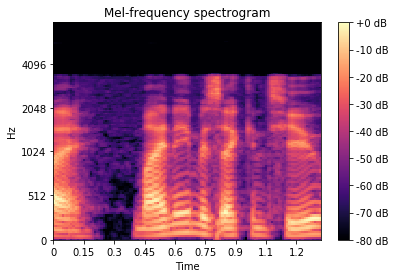

In [95]:
plot_spectrogram(spectrogram[:, 124:248], y[:, 0], sr)

In [90]:
print(spectrogram.shape) # break the spectrogram up into segments of 124?, every 3 seconds; also simpler
print(y.shape)
print(sr)

(128, 2251)
(1152000, 2)
48000
